### Mount Google Drive

In [16]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/CI2020-hackathon/James/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/CI2020-hackathon/James


In [7]:
device='gpu' # 'cpu'/'gpu'

In [26]:
if device=='gpu':
  gpu_info = !nvidia-smi
  print('\n'.join(gpu_info))
  device='cuda'

Sun Oct  4 11:39:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data

In [6]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import pandas as pd
import torch
import time
import pandas as pd
import os

In [30]:
CloudTop = np.load("../public_data/X_train_CI20.npy")
TrueColor = np.load("../public_data/Y_train_CI20.npy")
TrueColor.shape, CloudTop.shape

((8423, 127, 127, 3), (8423, 127, 127, 3))

Show an example

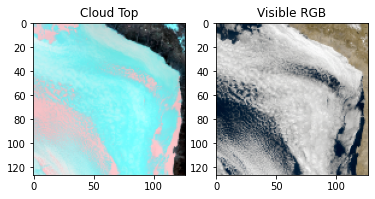

In [31]:
randindex = 5846 # np.random.randint(0,TrueColor.shape[0])

plt.figure()
plt.subplot(1,2,1)
plt.imshow(array_to_img(CloudTop[randindex,:,:,:]))
plt.title('Cloud Top')

plt.subplot(1,2,2)
plt.imshow(array_to_img(TrueColor[randindex,:,:,:]))
plt.title('Visible RGB')
plt.show()

Images are from day and night so we need to get rid of the night images

In [32]:
np.sum(np.sum(TrueColor,axis=(1,2,3))==0.)/TrueColor.shape[0]

0.46373026237682535

46% of images are all zeros. The full set of images are equally sampled from throughout the day, from midnight to midnight. So this seems roughly right

Let's check out the distribution of normalised pixel saturation of remaining images.

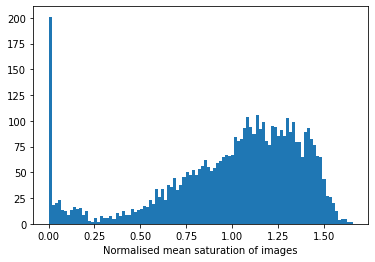

In [33]:
mask = np.where(np.sum(TrueColor,axis=(1,2,3))>0.)
TrueColorNZ = TrueColor[mask]
CloudTopNZ = CloudTop[mask]

# examine average intensities
saturation = ( TrueColorNZ.mean(axis=(1,2)) / (TrueColorNZ.mean(axis=(1,2)).mean(0)) ).mean(axis=1)
plt.hist(saturation, bins=100)
plt.xlabel('Normalised mean saturation of image')
plt.show()

In [21]:
# cutoff intensity
min_saturation = 0.6

TrueColorNZ = TrueColorNZ[saturation > min_saturation]
CloudTopNZ = CloudTopNZ[saturation > min_saturation]

In [22]:
TrueColorNZ.shape, CloudTopNZ.shape

((3880, 127, 127, 3), (3880, 127, 127, 3))

In [23]:
del CloudTop, TrueColor



## U-Net

In [24]:
from lib.unet import UNet
from lib.ssim import SSIM

In [27]:
model = UNet(in_channels=3, n_classes=3, depth=5, wf=3, padding=True, batch_norm=True, up_mode='upconv').to(device)
optim = torch.optim.Adam(model.parameters())
calc_ssim = SSIM()
loss_fn = lambda x1, x2: -calc_ssim(x1,x2)

In [28]:
from torchsummary import summary
summary(model, input_size=(3, 129, 129))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 129, 129]             224
              ReLU-2          [-1, 8, 129, 129]               0
       BatchNorm2d-3          [-1, 8, 129, 129]              16
            Conv2d-4          [-1, 8, 129, 129]             584
              ReLU-5          [-1, 8, 129, 129]               0
       BatchNorm2d-6          [-1, 8, 129, 129]              16
     UNetConvBlock-7          [-1, 8, 129, 129]               0
            Conv2d-8           [-1, 16, 64, 64]           1,168
              ReLU-9           [-1, 16, 64, 64]               0
      BatchNorm2d-10           [-1, 16, 64, 64]              32
           Conv2d-11           [-1, 16, 64, 64]           2,320
             ReLU-12           [-1, 16, 64, 64]               0
      BatchNorm2d-13           [-1, 16, 64, 64]              32
    UNetConvBlock-14           [-1, 16,

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

def pad(data):
  return F.pad(input=data, pad=(1, 1, 1, 1), mode='constant', value=0)

In [ ]:
batch_size = 32
test_size=500

tensor_x = pad(torch.from_numpy(CloudTopNZ.transpose((0,3,1,2))/255))
tensor_y = torch.from_numpy(TrueColorNZ.transpose((0,3,1,2))/255.)

dataset = TensorDataset(tensor_x,tensor_y)

# split into train and test sets and create dataloader
train_set, test_set = torch.utils.data.random_split(dataset, (len(dataset)-test_size, test_size), generator=torch.Generator().manual_seed(42))
dataloader = DataLoader(train_set, batch_size=batch_size)

test_X, test_y = test_set[:]
test_X = test_X.to(device)
test_y = test_y.to(device)

del tensor_x, tensor_y, train_set, test_set, dataset, CloudTopNZ, TrueColorNZ

In [ ]:
STATS_PERIOD = 50
MODEL_DUMP_ROOT="output_dump"

class net_container:
    def __init__(self, net, optimizer, loss_func, test_X, test_y, run_name=None):
        self.net = net
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.run_name = run_name
        self.test_X = test_X
        self.test_y = test_y
        
        self.running_train_loss = 0
        self.train_losses = []
        self.test_losses = []
        self.batch = []
        self.time_elapsed = []
        
    
    def train_step(self, X, y, batch_number):
        
        # zero the parameter gradients
        self.optimizer.zero_grad()

        # forward + backward + optimize
        self.net.train()
        
        outputs = self.net(X)[:,:,:-1, :-1]
        train_loss = self.loss_func(outputs, y)
        self.running_train_loss += train_loss.item()
        
        train_loss.backward()
        self.optimizer.step()

        # print statistics
        if batch_number == 0 or batch_number % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches

            # Train loss
            if batch_number == 0:
                mean_train_loss = self.running_train_loss
                self.t0 = time.time()
            else:
                mean_train_loss = self.running_train_loss / STATS_PERIOD

            self.train_losses.append(mean_train_loss)
            
            self.running_train_loss = 0.

            # Test loss
            self.net.eval()
            test_outputs = self.net(self.test_X)[:,:,:-1, :-1]
            
            test_loss = self.loss_func(test_outputs, self.test_y).item()
            self.test_losses.append(test_loss)
           
            self.batch.append(batch_number)
            self.time_elapsed.append(time.time() - self.t0)

            print(f"batch {batch_number} | {self.time_elapsed[-1]}s elapsed | train_loss {mean_train_loss:.5f} | test_loss {self.test_losses[-1]:.5f}"+" "*10, flush=True)
            
            if self.run_name:
                thisdir = os.path.join(MODEL_DUMP_ROOT, self.run_name)
                if batch_number==0:
                    
                    os.system(f"rm -rf {thisdir}")
                    os.makedirs(thisdir)
                    
                              
                df = pd.DataFrame({
                    'time_elapsed':self.time_elapsed,
                    'batch':self.batch,
                    'train_loss':self.train_losses,
                    'test_loss':self.test_losses,
                }).to_csv(os.path.join(thisdir, 'training_stats.csv'))
                
                if test_loss == min(self.test_losses):
                    torch.save(self.net, os.path.join(thisdir, 'best_model.pkl'))

In [ ]:
wrapped_model = net_container(model, optim, loss_fn, test_X, test_y, run_name='unet4')

bn = 0

In [ ]:
batch_epochs=[(10, 60), (32, 30), (64, 30), (128, 20), (256, 20)]

for batch_size, epochs in batch_epochs:

  print(f"transition to (batch:{batch_size}, epochs: {epochs})")
  dataloader = DataLoader(dataloader.dataset, batch_size=batch_size)

  for _ in range(epochs):
      
      for X, y in dataloader:
          X = X.to(device)
          y = y.to(device)
          wrapped_model.train_step(X,y,bn)
          bn+=1

## Evaluate and reload best model

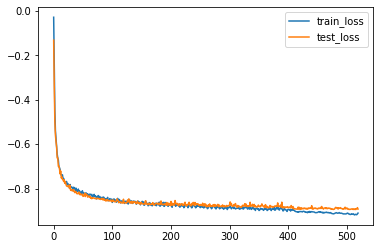

In [ ]:
df = pd.read_csv('output_dump/unet4/training_stats.csv')
df = df[df.train_loss>-1]
df.plot(y=['train_loss', 'test_loss'])

Train and test loss are essentially the same so could use bigger network with more parameters

In [ ]:
df.test_loss.min()

-0.8948780298233032

In [ ]:
model = torch.load('output_dump/unet4/best_model.pkl')

Text(0.5, 1.0, 'Predicted - loss -0.9010334610939026')

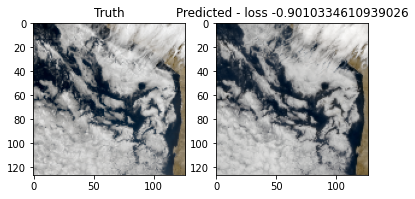

In [ ]:
randindex = np.random.randint(0,test_y.shape[0])

img_y_hat = model(test_X[randindex:randindex+1])[:,:, :-1, :-1]
img_y = test_y[randindex:randindex+1,:,:,:]

def post_process(imgs):
  return imgs[0].detach().cpu().numpy().transpose((1,2,0))*255

plt.figure()
plt.subplot(1,2,1)
plt.imshow(array_to_img(post_process(img_y)))
plt.title('Truth')

plt.subplot(1,2,2)
plt.imshow(array_to_img(post_process(img_y_hat)))
plt.title(f'Predicted - loss {loss_fn(img_y_hat, img_y)}')

In [ ]:
X_test = np.load("../public_data/X_test_CI20_phase1.npy")

X_test = pad(torch.from_numpy(X_test.transpose((0,3,1,2))/255)).to(device)

predictions = model(X_test).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255

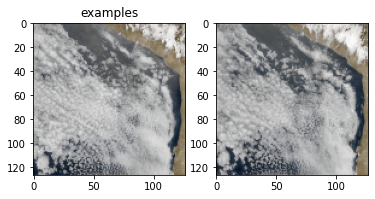

In [ ]:
i=133

plt.figure()
plt.subplot(1,2,1)
plt.imshow(array_to_img(predictions[i]))
plt.title('examples')

plt.subplot(1,2,2)
plt.imshow(array_to_img(predictions[i+1]))


look at the analogs of one random test image

## Submitting to the online challenge



In [ ]:
predictions_file = "predictions"

def save_compress(predictions, name):
    np.save(f'{predictions_file}/{name}.npy', predictions)
    os.system(f"mv {predictions_file}/{name}.npy {predictions_file}/{name}.predict")
    os.system(f"zip -jrm {predictions_file}/{name}.zip {predictions_file}/{name}.predict")
    os.system(f"rm {predictions_file}/{name}.predict")

save_compress(predictions, 'Y_test_CI20_phase1_UNet4_best')